In [1]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator

from scipy.integrate import quad, nquad
from scipy import stats

from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
import pickle
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

bh kick speed = 100
3e-7 pbh mass
f = 1e-4
long = 1.0
lat = -1.03
distribution of t_es
cadence =
tobs = 1875

In [2]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [3]:
roman_df = pd.read_csv('roman_sensitivity.csv', header=None, names=['t_e [days]', 'efficiency'])
roman_efficiency_interp = interp1d(roman_df['t_e [days]'], roman_df['efficiency'])
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    '''
    t_day = t/24
    if t_day <= np.min(roman_df['t_e [days]']):
        return roman_df['efficiency'][0]
    if t_day >= np.max(roman_df['t_e [days]']):
        return roman_df['efficiency'][len(roman_df)-1]
    return(roman_efficiency_interp(t_day))

In [4]:
# def roman_efficiency(t):
#     '''
#     Takes in crossing time in hours and returns the efficiency of Roman
#     #Need to replace this eventually. Assume perfect efficiency for now
#     '''
#     return 1.0


In [5]:
#A_t of 1.06 corresponds to u_t_point of ~2, which is what popsycle uses as u_0_max
survey_param_dict = {
    "mock_roman": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 1825*24, "cadence": 15/60,  "n_sources": 1e7, "efficiency": roman_efficiency, "A_t": 1.06, "survey_area":0},
    # "mock_roman": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 1825*24, "cadence": 15/60,  "n_sources": 1e7, "efficiency": roman_efficiency, "A_t": 1.34, "survey_area":0},

}

In [6]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

def scientific_format_less(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"$10^{{{}}}$".format(int(exponent))

In [7]:
# Define Time Array
s = Survey(**survey_param_dict["mock_roman"])
# t_es = np.logspace(np.log10(s.cadence)-0.5, np.log10(s.obs_time)+0.5, 60) #hours

def gamma_of_t(dgamma_dt, t, t_es):
    t_min = t * 10**(-0.1)
    t_max = t * 10**(0.1)
    diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))
    def diff_rates_interp(t):
        return 10**diff_rates_interp_log(np.log10(t))
    return quad(diff_rates_interp, t_min, t_max)[0]

def sample_crossing_times(t_es, gammas, n_samples):
    norm_gammas = gammas/np.sum(gammas)
    cdf = np.cumsum(norm_gammas)
    
    samples = []
    for _ in range(n_samples):
        r = np.random.rand()
        t_e_sample = np.interp(r, cdf, t_es)
        samples.append(t_e_sample)
    return np.array(samples)

In [8]:
s

Survey(l=1.0, b=-1.03, source_dist=8.5, obs_time=43800, cadence = 0.25, survey_area=0, n_sources=10000000.0, efficiency=<function roman_efficiency at 0x7f9cb85563a0>)

Line of Sight

In [9]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d, l = s.l, b = s.b) for d in d_arr]
    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    ax.set_title(r'MW Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e5, 1e10)


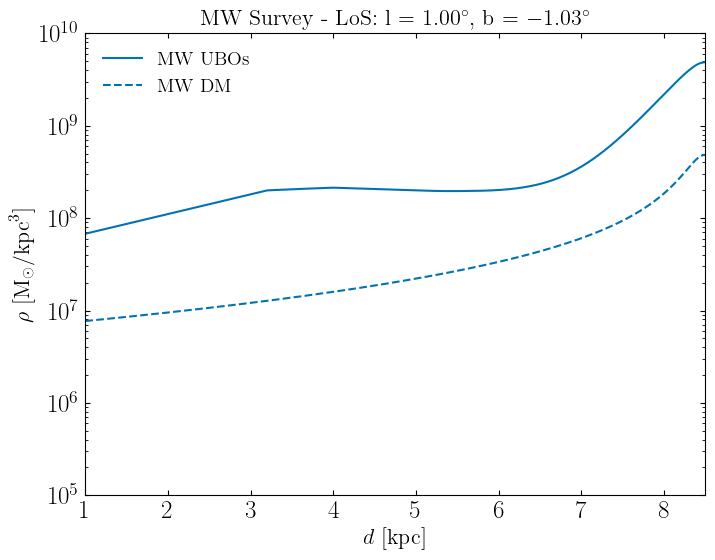

In [10]:
plot_line_of_sight(s, plt.gca())

In [11]:
# Initialize an empty dictionary
data_structure = {
    "ffp": {},
    "pbh": {}
}

def store_values(case, finite, v_disp, p=None, mass=None, t_es=None, calculated_values=None):
    if case not in data_structure:
        raise ValueError("Invalid case. Valid cases are 'ffp' and 'pbh'.")

    if finite not in data_structure[case]:
        data_structure[case][finite] = {}

    if v_disp not in data_structure[case][finite]:
        data_structure[case][finite][v_disp] = {}

    if case == "ffp":
        if p is not None:
            data_structure[case][finite][v_disp][p] = {
                "t_es": t_es,
                "calculated_values": calculated_values
            }
        else:
            raise ValueError("Parameter 'p' is required for case 'ffp'.")
    elif case == "pbh":
        if mass is not None:
            data_structure[case][finite][v_disp][mass] = {
                "t_es": t_es,
                "calculated_values": calculated_values
            }
        else:
            raise ValueError("Parameter 'mass' is required for case 'pbh'.")


In [11]:
# t_es = np.logspace(np.log10(s.cadence)-0.1, np.log10(s.obs_time)+0.1, 60) #hours
# t_es = np.logspace(-1.1, 4.5, 60) #hours
t_es = np.logspace(-2, 4.8, 60) #hours

v_disp_pbh = 250
pbh_masses = np.array([3e-6, 30])
# pbh_masses = np.logspace(-12, 2, 30)

t_low_cut = s.cadence
t_high_cut = s.obs_time

def differential_rate_mw_t_e_pbh(t, s=s, finite=False):
    return s.pbh.differential_rate_mw(t, finite=False, v_disp=v_disp_pbh, t_e=True, tmin=t_low_cut, tmax=t_high_cut)

def differential_rate_mw_duration_pbh(t, s=s, finite=False):
    return s.pbh.differential_rate_mw(t, finite=finite, v_disp=v_disp_pbh, t_e=False)

for mass in pbh_masses:
    s.add_pbh(mass)

    with Pool() as pool:
        func = functools.partial(differential_rate_mw_t_e_pbh, s=s, finite=False)
        pbh_tes_point  = list(tqdm(pool.imap(func, t_es), total=len(t_es)))
    pbh_tes_point = np.array(pbh_tes_point)

    # with Pool() as pool:
    #     func = functools.partial(differential_rate_mw_duration_pbh, s=s, finite=False)
    #     pbh_duration_point  = list(tqdm(pool.imap(func, t_es), total=len(t_es)))
    # pbh_duration_point = np.array(pbh_duration_point)

    # with Pool() as pool:
    #     func = functools.partial(differential_rate_mw_duration_pbh, s=s, finite=True)
    #     pbh_duration_finite  = list(tqdm(pool.imap(func, t_es), total=len(t_es)))
    # pbh_duration_finite = np.array(pbh_duration_finite)

    store_values(case="pbh", finite=False, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_tes_point)
    # store_values(case="pbh", finite=True, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_duration_finite)
    # store_values(case="pbh", finite=False, v_disp=v_disp_pbh, mass=mass, t_es=t_es, calculated_values=pbh_duration_point)



  0%|          | 0/60 [00:00<?, ?it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/utils.py:100: RuntimeWarning: invalid value encountered in scalar power
  return 2* (1 - ((umin + rho)/ut)**2)**(1/2) * einstein_rad(d, mass) * kpctokm * (ut + rho) / v_rel
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/utils.py:100: RuntimeWarning: invalid value encountered in scalar power
  return 2* (1 - ((umin + rho)/ut)**2)**(1/2) * einstein_rad(d, mass) * kpctokm * (ut + rho) / v_rel
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/utils.py:100: RuntimeWarning: invalid value encountered in scalar power
  return 2* (1 - ((umin + rho)/ut)**2)**(1/2) * einstein_rad(d, mass) * kpctokm * (ut + rho) / v_rel
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/utils.py:100: RuntimeWarning: invalid value encountered in scalar power
  return 2* (1 - ((umin + rho)/ut)**2)**(1/2) * einstein_rad(d, mass) * kpctokm * (ut +

### FFPs

In [12]:
# t_es_ffps = np.logspace(-3, 2.5, 50) #hours
t_es_ffps = np.logspace(-2, 4.8, 50) #hours

M_norm = 3e-6
Z_fiducial = 10
v_disp_ffp = 200

p_arr = np.array([0.66, 1.0, 1.33])
# p_arr = np.linspace(0.66, 1.33, 16)

# t_low_cut = s.cadence
t_low_cut = s.cadence*100
t_high_cut = s.obs_time


def differential_rate_mw_t_e(t, s=s, finite=False):
    v_disp_ffp = 200
    return s.ffp.differential_rate_mw(t, finite=finite, v_disp=v_disp_ffp, t_e=True, tmin=t_low_cut, tmax=t_high_cut)

# def differential_rate_mw_duration(t, s=s, finite=False):
    # v_disp_ffp = 200
    # return s.ffp.differential_rate_mw(t, finite=finite, v_disp=v_disp_ffp, t_e=False)

for p in p_arr:
    # s.add_ffp(p, m_min = 1e-9, m_max = 1e-1)
    s.add_ffp(p, m_min = 1e-12, m_max = 1e-1)

    z_earth =  Z_fiducial/(s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p))

    with Pool() as pool:
        func_ffp = functools.partial(differential_rate_mw_t_e, s=s, finite=False)
        ffp_tes_point  = list(tqdm(pool.imap(func_ffp, t_es_ffps), total=len(t_es_ffps)))
    ffp_tes_point = np.array(ffp_tes_point)

    # with Pool() as pool:
    #     func_ffp = functools.partial(differential_rate_mw_duration, s=s, finite=True)
    #     ffp_t_duration_finite  = list(tqdm(pool.imap(func_ffp, t_es_ffps), total=len(t_es_ffps)))
    # ffp_t_duration_finite = np.array(ffp_t_duration_finite)

    # with Pool() as pool:
    #     func_ffp = functools.partial(differential_rate_mw_duration, s=s, finite=False)
    #     ffp_t_duration_point  = list(tqdm(pool.imap(func_ffp, t_es_ffps), total=len(t_es_ffps)))
    # ffp_t_duration_point = np.array(ffp_t_duration_point)

    ffp_tes_point = ffp_tes_point*z_earth
    # ffp_t_duration_finite = ffp_t_duration_finite*z_earth
    # ffp_t_duration_point = ffp_t_duration_point*z_earth


    store_values(case="ffp", finite=False, v_disp=v_disp_ffp, p=p, t_es=t_es_ffps, calculated_values=ffp_tes_point)
    # store_values(case="ffp", finite=True, v_disp=v_disp_ffp, p=p, t_es=t_es_ffps, calculated_values=ffp_t_duration_finite)
    # store_values(case="ffp", finite=False, v_disp=v_disp_ffp, p=p, t_es=t_es_ffps, calculated_values=ffp_t_duration_point)



100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


In [15]:
def plot_data_structure(data_structure):
    num_entities = len(data_structure)
    fig, axes = plt.subplots(num_entities, 1, figsize=(6, 4*num_entities), sharex=True)

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        ax = axes[idx]
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():
                    if entity == "ffp":
                        ax.loglog(p_or_mass_data['t_es'], p_or_mass_data['calculated_values'], label=f'p={p_or_mass}, v_disp={v_disp}, finite={finite_val}')
                    else:
                        ax.loglog(p_or_mass_data['t_es'], p_or_mass_data['calculated_values'], label=f'mass={p_or_mass}, v_disp={v_disp}, finite={finite_val}')
        
        ax.set_xlabel('t [hours]')
        ax.set_ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
        ax.set_ylim(1e-16, 1e-4)
        ax.set_title(f'{entity}')
        ax.legend()
    plt.tight_layout()
    plt.show()

def plot_gammas(data_structure):
    num_entities = len(data_structure)
    fig, axes = plt.subplots(num_entities, 1, figsize=(6, 4*num_entities))

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():
                    # Calculate gamma(t) for each case
                    t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                    gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                    
                    # Plot gamma(t)
                    axes[idx].loglog(t_es_limited, gammas, label=f'p_or_mass={p_or_mass}, v_disp={v_disp}, finite={finite_val}')

        axes[idx].set_xlabel(r'$t_E$ [hours]')
        axes[idx].set_ylabel(r'$\Gamma(t)$')
        axes[idx].set_ylim(1e-16, 1e-5)
        axes[idx].set_title(f'{entity}')
        # axes[idx].legend()
        
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


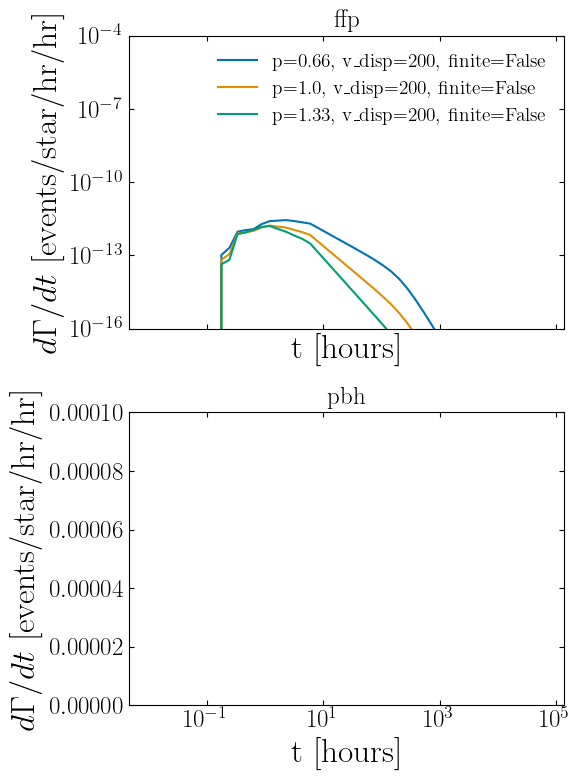

In [16]:
plot_data_structure(data_structure)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_60760/3285702519.py:8: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))


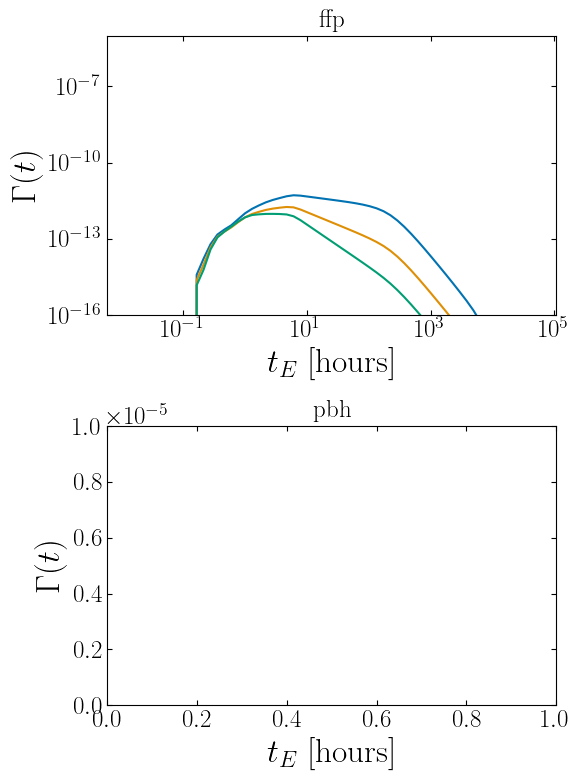

In [17]:
plot_gammas(data_structure)

In [19]:
def create_gamma_interp_ffp(data_structure):
    t_values = []
    p_values = []
    gamma_values = []
    dgammadt_values = []

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        if entity != "ffp":
            continue
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():
                    # if p_or_mass != 1.0:
                        # continue
                    # Calculate gamma(t) for each case
                    t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                    gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                    t_values.extend(p_or_mass_data['t_es'])

                    p_values.extend([p_or_mass] * len(t_es_limited))
                    gamma_values.extend(gammas)
                    dgammadt_values.extend(p_or_mass_data['calculated_values'])

    # Evaluate the gamma values at the points in the grid
    gamma_values_grid = np.array(gamma_values).reshape(len(p_arr), (len(t_es_limited)))
    dgammadt_values_grid = np.array(dgammadt_values).reshape(len(p_arr), (len(np.unique(t_values))))

    # Create an interpolating function
    gamma_interpolating_function = RegularGridInterpolator((p_arr, t_es_limited), gamma_values_grid, method='linear')
    dgammadt_interpolating_function = RegularGridInterpolator((p_arr, np.unique(t_values)), dgammadt_values_grid, method='linear')
    dgammadt_interpolating_function = RegularGridInterpolator((np.log10(p_arr), np.log10(np.unique(t_values))), np.log10(dgammadt_values_grid), method='linear')


    return dgammadt_interpolating_function, gamma_interpolating_function

def create_gamma_interp_pbh(data_structure):
    t_values = []
    m_values = []
    gamma_values = []
    dgammadt_values = []

    for idx, (entity, entity_data) in enumerate(data_structure.items()):
        if entity != "pbh":
            continue
        for finite_val, finite_data in entity_data.items():
            for v_disp, v_disp_data in finite_data.items():
                for p_or_mass, p_or_mass_data in v_disp_data.items():

                    t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                    gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                    t_values.extend(p_or_mass_data['t_es'])
                    m_values.extend([p_or_mass] * len(np.unique(t_values)))
                    gamma_values.extend(gammas)
                    dgammadt_values.extend(p_or_mass_data['calculated_values'])
                    

    # Evaluate the gamma values at the points in the grid
    # gamma_values_grid = np.array(gamma_values).reshape(len(pbh_masses), (len(t_es_limited)))
    dgammadt_values_grid = np.array(dgammadt_values).reshape(len(pbh_masses), (len(np.unique(t_values))))
    # Create an interpolating function
    # gamma_interpolating_function = RegularGridInterpolator((pbh_masses, t_es_limited), gamma_values_grid, method='linear')
  
    # dgammadt_interpolating_function = RegularGridInterpolator((pbh_masses, np.unique(t_values)), dgammadt_values_grid, method='linear')
    dgammadt_interpolating_function = RegularGridInterpolator((np.log10(pbh_masses), np.log10(np.unique(t_values))), np.log10(dgammadt_values_grid), method='linear')

    # return gamma_interpolating_function
    return dgammadt_interpolating_function


In [18]:
# dgammadt_func_pbh_finite = create_gamma_interp_pbh(data_structure)
# pickle.dump(dgammadt_func_pbh_finite, open("interps/dgammadt_func_pbh_finite.p", "wb"))
dgammadt_func_pbh_finite = pickle.load(open("interps/dgammadt_func_pbh_finite.p", "rb"))

In [19]:
# gamma_func_pbh_finite = create_gamma_interp_pbh(data_structure)
# pickle.dump(gamma_func_pbh_finite, open("interps/gamma_func_pbh_finite.p", "wb"))
# gamma_func_pbh_point = create_gamma_interp_pbh(data_structure)
# pickle.dump(gamma_func_pbh_point, open("interps/gamma_func_pbh_point.p", "wb"))
gamma_func_pbh = pickle.load(open("interps/gamma_func_pbh_point.p", "rb"))
gamma_func_pbh_finite = pickle.load(open("interps/gamma_func_pbh_finite.p", "rb"))


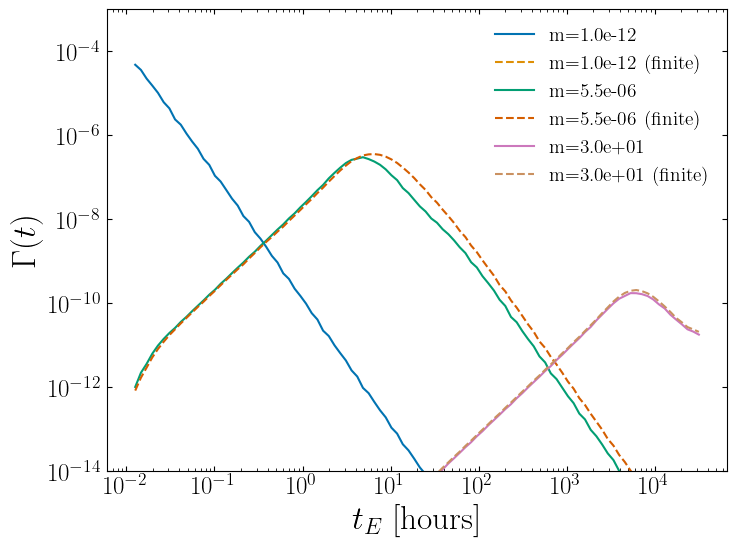

In [20]:
t_es_extended = np.logspace(-1.9, 4.5, 100) #hours
m_arr_extended = np.logspace(-12, np.log10(30), 3)

for m in m_arr_extended:
    plt.plot(t_es_extended, np.array([gamma_func_pbh([[m, t]]) for t in t_es_extended]).flatten(), label=f"m={m:.1e}")
    plt.plot(t_es_extended, np.array([gamma_func_pbh_finite([[m, t]]) for t in t_es_extended]).flatten(), label=f"m={m:.1e} (finite)", ls="--")

plt.xlabel(r'$t_E$ [hours]')
plt.ylabel(r'$\Gamma(t)$')
plt.ylim(1e-14, 1e-3)
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [20]:
dgammadt_func_ffp_finite, gamma_func_ffp_finite = create_gamma_interp_ffp(data_structure)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_60760/3285702519.py:8: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_60760/2036986455.py:31: RuntimeWarning: divide by zero encountered in log10
  dgammadt_interpolating_function = RegularGridInterpolator((np.log10(p_arr), np.log10(np.unique(t_values))), np.log10(dgammadt_values_grid), method='linear')


In [31]:
# dgammadt_func_ffp_finite = create_gamma_interp_ffp(data_structure)
# pickle.dump(dgammadt_func_ffp_finite, open("interps/dgammadt_func_ffp_finite.p", "wb"))
# dgammadt_func_ffp_finite = pickle.load(open("interps/dgammadt_func_ffp_finite.p", "rb"))

In [32]:
# gamma_func = create_gamma_interp_ffp(data_structure)
# gamma_func_ffp_finite = create_gamma_interp_ffp(data_structure)
# pickle.dump(gamma_func_ffp_finite, open("interps/gamma_func_ffp_finite.p", "wb"))
# gamma_func_ffp_point = create_gamma_interp_ffp(data_structure)
# pickle.dump(gamma_func_ffp_point, open("interps/gamma_func_ffp_point.p", "wb"))
gamma_func_ffp = pickle.load(open("interps/gamma_func_ffp_point.p", "rb"))
gamma_func_ffp_finite = pickle.load(open("interps/gamma_func_ffp_finite.p", "rb"))


In [21]:
def sample_t_es(p, t_es, gamma_func, n_samples=1000):
    pmin = min(gamma_func.grid[0])
    pmax = max(gamma_func.grid[0])
    tmin = min(gamma_func.grid[1])
    tmax = max(gamma_func.grid[1])
    if p < pmin or p > pmax:
        raise ValueError(f"p = {p} is outside of the range of p values in the interpolating function: {pmin} to {pmax}")
    if min(t_es) < tmin:
        raise ValueError(f"t_e = {min(t_es)} is outside of the range of t_e values in the interpolating function: {tmin} to {tmax}")
    if max(t_es) > tmax:
        raise ValueError(f"t_e = {max(t_es)} is outside of the range of t_e values in the interpolating function: {tmin} to {tmax}")
    
    gammas = np.array([gamma_func([[p, t]]) for t in t_es])

    samples = sample_crossing_times(t_es, gammas, n_samples)
    return samples
    

In [22]:
ts_sample = np.logspace(-1.9, 3, 100)
sampled_t_es = sample_t_es(1.0, ts_sample, gamma_func_ffp, n_samples=1000)

NameError: name 'gamma_func_ffp' is not defined

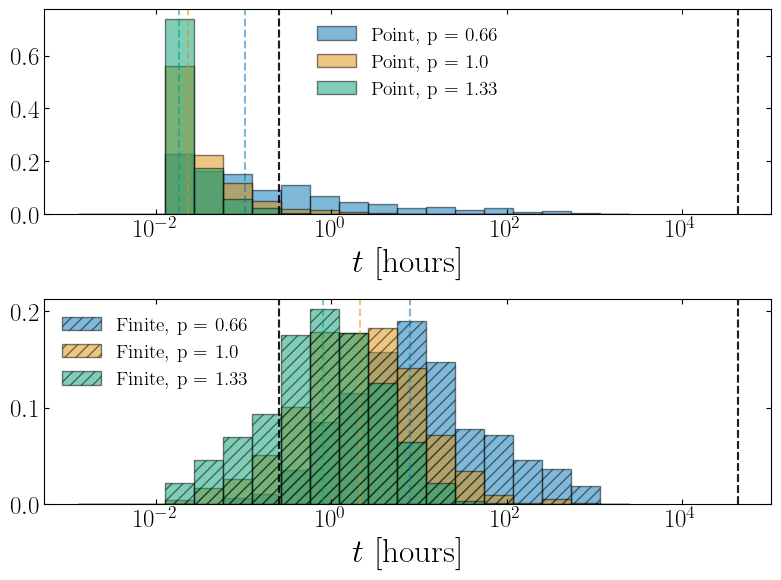

In [25]:
# Create a 1x2 grid of subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
colors = sns.color_palette("colorblind", len(p_arr))
bins = np.logspace(-2.9, 3.4, 20)


# Loop through each value of p
for i, p in enumerate(p_arr):
    sampled_t_es = sample_t_es(p, ts_sample, gamma_func_ffp, n_samples=1000)
    sampled_t_es_finite = sample_t_es(p, ts_sample, gamma_func_ffp_finite, n_samples=1000)

    bin_counts, bin_edges = np.histogram(sampled_t_es, bins=bins)
    bin_counts_finite, bin_edges_finite = np.histogram(sampled_t_es_finite, bins=bins)
    color = colors[i]

    # Point case on the first subplot
    axes[0].bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f'Point, p = {p}', alpha=0.5, color=color)
    axes[0].axvline(np.median(sampled_t_es), linestyle="--", alpha=0.5, color=color)
    axes[0].axvline(s.cadence, linestyle="--", alpha=0.5, color='k')
    axes[0].axvline(s.obs_time, linestyle="--", alpha=0.5, color='k')

    # Finite case on the second subplot
    axes[1].bar(bin_edges_finite[:-1], bin_counts_finite/np.sum(bin_counts_finite), width=np.diff(bin_edges_finite), align="edge", edgecolor="black", label=f'Finite, p = {p}', alpha=0.5, color=color, hatch="///")
    axes[1].axvline(np.median(sampled_t_es_finite), linestyle="--", alpha=0.5, color=color)
    axes[1].axvline(s.cadence, linestyle="--", alpha=0.5, color='k')
    axes[1].axvline(s.obs_time, linestyle="--", alpha=0.5, color='k')

# Set log scale and legend for both subplots
for ax in axes:
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel(r"$t$ [hours]")

plt.tight_layout()
plt.show()

In [85]:
#From table 2
(0.24)* (0.1/95)**(-0.73) * 17.9

640.9180527732299

In [86]:
(0.24)* (0.01/95)**(-0.73) * 1.22


234.58989682260176

In [89]:
249+865

1114

In [88]:
640.9180527732299 + 234.58989682260176 - 10 -0.7

864.8079495958316

In [80]:
(95**(0.73) * 0.24)/10

0.6667291964938795

In [78]:
def gamma_wrapper(t):
    return dgammadt_func_ffp_finite([[0.73, t]]) * s.efficiency(t)
# quad(gamma_wrapper, 0.25, 1825*24)[0] * s.n_sources * s.obs_time 
quad(gamma_wrapper, 0.25, 1825*24)[0] * 1e8 * 6*72*24 * 0.667


207.12677007778646

In [47]:
def yield_ffp(p):
    def gamma_wrapper(t):
        return 10**(dgammadt_func_ffp_finite([[np.log10(p), np.log10(t)]])) * s.efficiency(t)
    return quad(gamma_wrapper, 0.25, 1825*24, epsabs=0, epsrel=1e-1)[0] * s.n_sources * s.obs_time 

def yield_pbh(m):
    def gamma_wrapper(t):
        return 10**(dgammadt_func_pbh_finite([[np.log10(m), np.log10(t)]])) * s.efficiency(t)
    return quad(gamma_wrapper, 0.25, 1825*24, epsabs=0, epsrel=1e-1)[0] * s.n_sources * s.obs_time 

In [89]:
yield_ffp(0.73)*0.667

207.9191489109249

In [49]:
yield_pbh(1e-4)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_41330/2979419074.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(gamma_wrapper, 0.25, 1825*24, epsabs=0, epsrel=1e-1)[0] * s.n_sources * s.obs_time


45643.36779643568

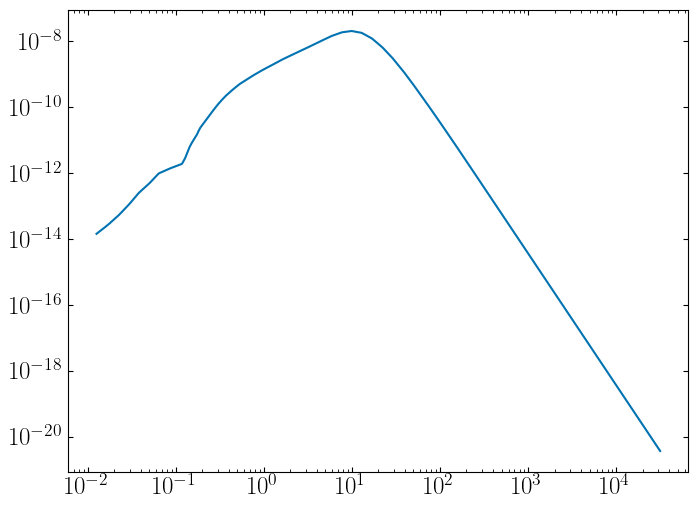

In [50]:
t_arr_extedned = np.logspace(-1.9, 4.5, 1000) #hours
dgamma_values = np.array([10**(dgammadt_func_pbh_finite([[np.log10(1e-5), np.log10(t)]])) * s.efficiency(t) for t in t_arr_extedned])
plt.loglog(t_arr_extedned, dgamma_values)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_41330/2979419074.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(gamma_wrapper, 0.25, 1825*24, epsabs=0, epsrel=1e-1)[0] * s.n_sources * s.obs_time
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_41330/2979419074.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(gamma_wrapper, 0.25, 1825*24, epsabs=0, epsrel=1e-1)[0] * s.n_sources * s.obs_time


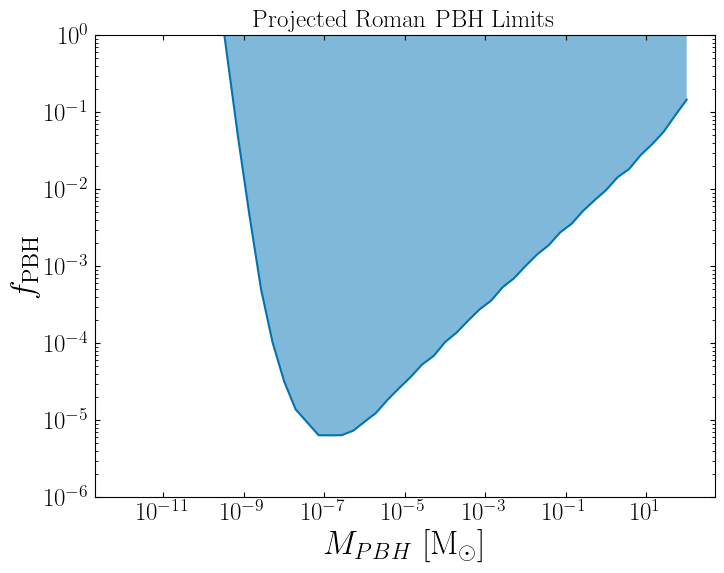

In [70]:
mass_arr = np.logspace(-12, 2, 50)
yield_pbh_arr = np.array([yield_pbh(m) for m in mass_arr])
plt.loglog(mass_arr, 4.74/yield_pbh_arr, label="PBH")
plt.fill_between(mass_arr, 4.74/yield_pbh_arr, 1, alpha=0.5)
plt.ylim(1e-6, 1)
plt.xlabel(r"$M_{PBH}$ [M$_\odot$]")
plt.ylabel(r"$f_{\rm{PBH}}$")
plt.title('Projected Roman PBH Limits')
plt.show()


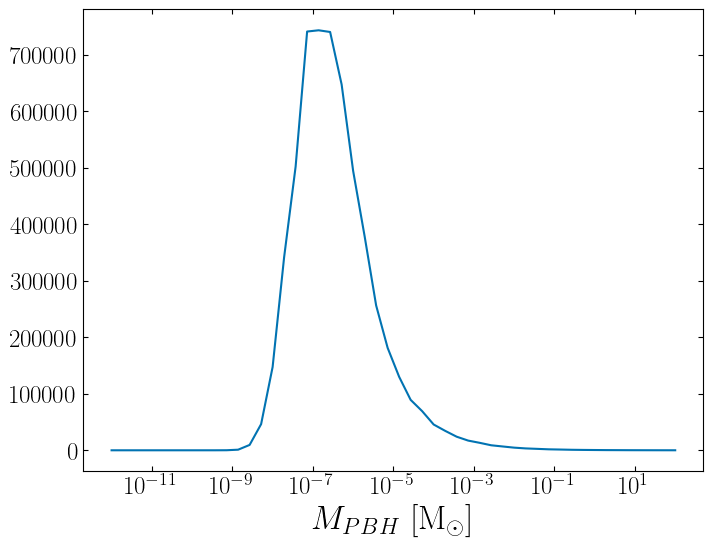

In [91]:
plt.plot(mass_arr,yield_pbh_arr, label="PBH")
plt.xscale("log")
plt.xlabel(r"$M_{PBH}$ [M$_\odot$]")
plt.show()

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_41330/2979419074.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(gamma_wrapper, 0.25, 1825*24, epsabs=0, epsrel=1e-1)[0] * s.n_sources * s.obs_time


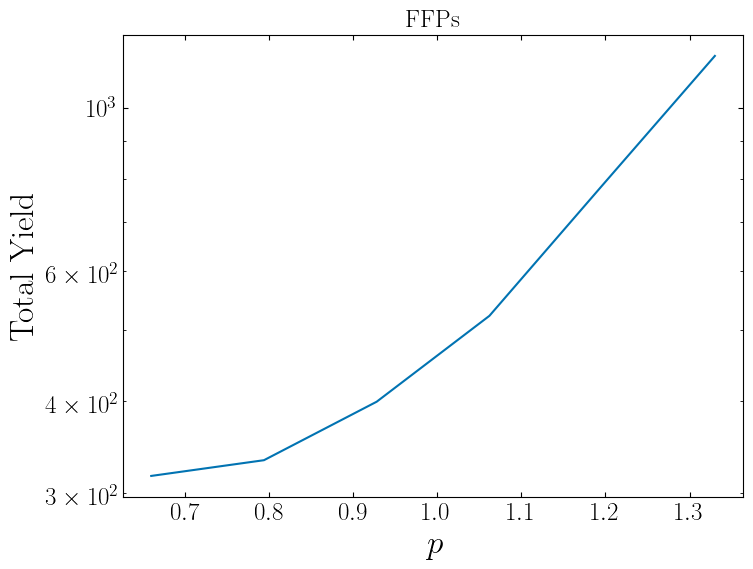

In [64]:
p_arr = np.linspace(0.66, 1.33, 6)
yield_ffp_arr = np.array([yield_ffp(p) for p in p_arr])
plt.plot(p_arr, yield_ffp_arr, label="FFP")
plt.yscale("log")
# plt.ylim(1e-6, 1)
plt.xlabel(r"$p$")
plt.ylabel(r"Total Yield")
plt.title('FFPs')
plt.show()

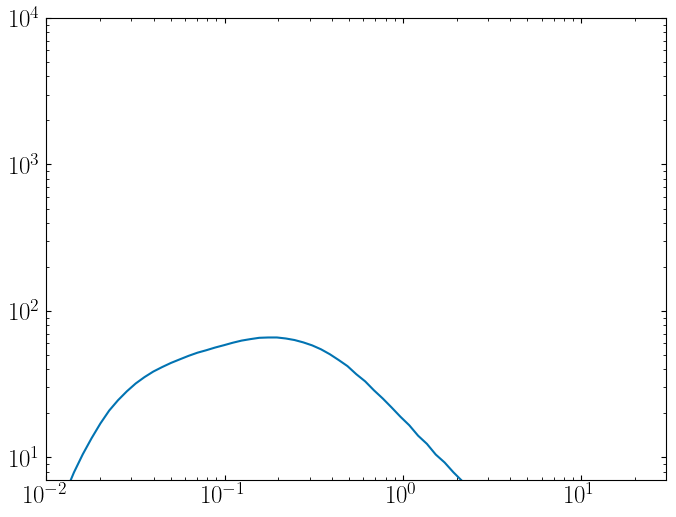

In [87]:
dN_dt = np.array([gamma_func_ffp_finite([[1, t]]) * s.efficiency(t) for t in np.logspace(-1.9,3,100)])
# plt.loglog(np.logspace(-1.9,3,100)/24, dN_dt*1e8 * 6*72*24 * 0.667)
plt.loglog(np.logspace(-1.9,3,100)/24, dN_dt* s.n_sources * s.obs_time)

plt.xlim(0.01, 30)
plt.ylim(7e0, 1e4)
plt.show()

### Mass Sensitivity

In [10]:
def differential_rate_mw_mass(m, tcad = 0.07, tobs= 3, finite=True):
    # return s.ffp.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite, epsabs=0, epsrel=1e-1)
    return s.ffp.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite, efficiency=s.efficiency)


In [11]:
m_arr = np.logspace(-10, 0, 40)
with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, tcad=s.cadence, tobs=s.obs_time, finite=True)
    d_gamma_d_ms  = list(tqdm(pool.imap(func, m_arr), total=len(m_arr)))
d_gamma_d_ms = np.array(d_gamma_d_ms)

100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


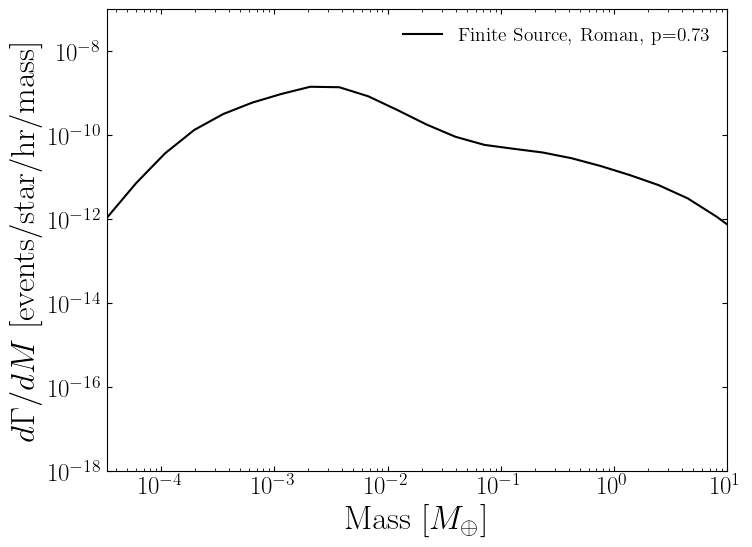

In [12]:
plt.loglog(m_arr/3e-6, d_gamma_d_ms, label=f'Finite Source, Roman, p={p}', color='k')

plt.ylim(1e-18, 1e-7)
plt.xlim(np.min(m_arr)/3e-6, 1e1)

plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]")
plt.legend()
plt.show()

In [29]:
roman_diff_rate_mw_interp_log = interp1d(np.log10(m_arr), np.log10(d_gamma_d_ms))
def diff_rates_m_mw_interp(m):
    return 10**roman_diff_rate_mw_interp_log(np.log10(m))
roman_rates = np.array([quad(diff_rates_m_mw_interp, m_arr[i],m_arr[i+1])[0] for i in range(len(m_arr)-1)])

mean_values = (m_arr[:-1] + m_arr[1:]) / 2
rate_interp_log = interp1d(np.log10(mean_values), np.log10(roman_rates))

def roman_rates_interp(m):
    return 10**rate_interp_log(np.log10(m))

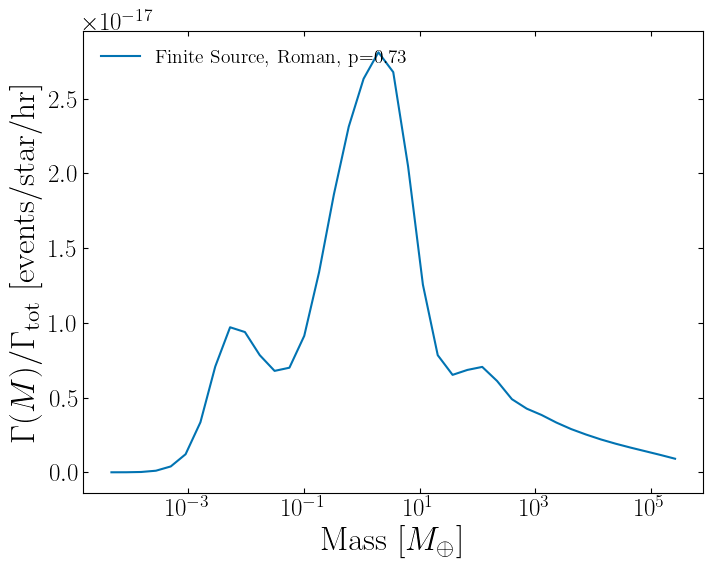

In [30]:
plt.plot(mean_values/3e-6, roman_rates, label=f'Finite Source, Roman, p={p}')

plt.xscale('log')
plt.xlabel("Mass [$M_{\oplus}$]")
plt.ylabel(r"$\Gamma(M)/\Gamma_{\rm{tot}}$ [events/star/hr]")
# plt.title('MW lens w finite-source effects, M31 source')
plt.legend(loc='upper left')
plt.show()

## Comparison with Popsycle

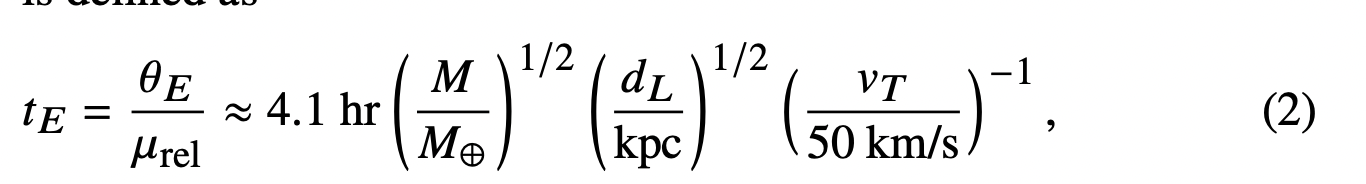

In [21]:
t_e_typical = 4.1 * (1e7)**(1/2) * (4)**(1/2) * (280/50)**(-1) / 24 # 30 solar mass, days
# t_e_typical = 4.1 * (1)**(1/2) * (8)**(1/2) * (280/50)**(-1) #earth mass, hours
print(t_e_typical)

192.9365834328922


In [22]:
4.1 * (1e-6)**(1/2) * (8)**(1/2) * (280/50)**(-1) #earth mass, hours


0.002070812716332032

In [12]:
nick_tes_30 = pd.read_csv('popsycle_data/nick-t_E-30msun-sep8-nocut.csv', header=None).values.flatten()
nick_tes_earth = pd.read_csv('popsycle_data/nick-t_E-earthmass-sep8.csv', header=None).values.flatten()
nick_tes_data = {
    3e-6: nick_tes_earth, 
    30: nick_tes_30 
}

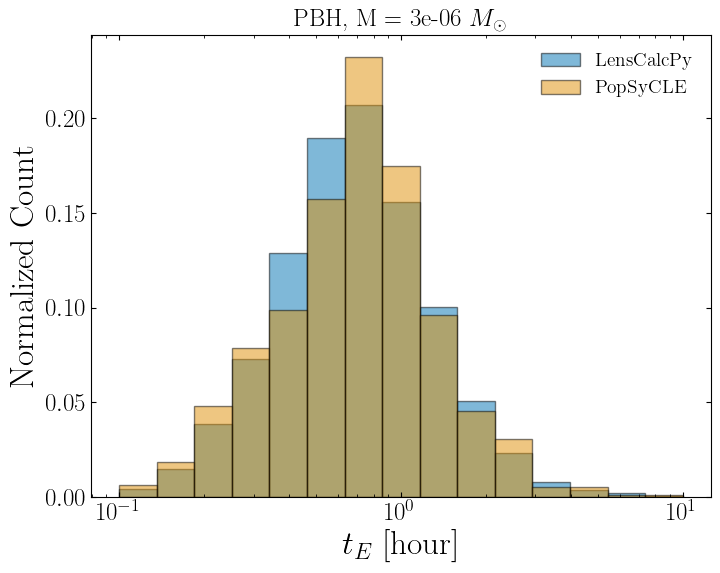

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_47349/3285702519.py:8: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))


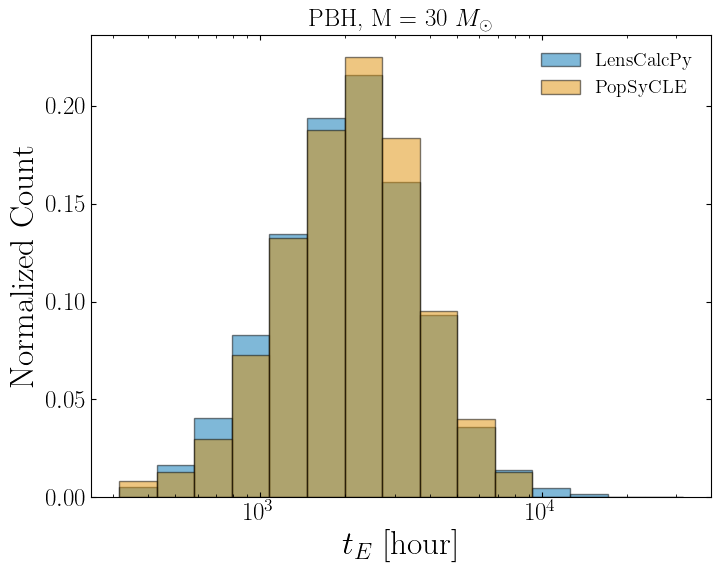

In [20]:
def plot_histograms(data_structure, nick_tes_data, num_samples=10000, num_bins=24):

    for m_pbh, nick_tes in nick_tes_data.items():
        if m_pbh == 3e-6:
            bins = np.logspace(-1, 1, num_bins)
        elif m_pbh == 30:
            bins = np.logspace(2.5, 4.5, num_bins)

        plt.figure()
        for entity, entity_data in data_structure.items():
            for finite_val, finite_data in entity_data.items():
                if finite_val:
                    continue
                for v_disp, v_disp_data in finite_data.items():
                    for p_or_mass, p_or_mass_data in v_disp_data.items():
                        if entity != 'pbh' or p_or_mass != m_pbh:
                            continue
                        # Calculate gamma(t) for each case
                        t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                        gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                        
                        # Sample crossing times
                        samples = sample_crossing_times(t_es_limited, gammas, num_samples)
                        
                        # Plot histogram
                        bin_counts, bin_edges = np.histogram(samples, bins=bins)
                        plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LensCalcPy', alpha=0.5)
                        # plt.axvline(np.mean(samples), linestyle="--", alpha=0.5)

        # Plotting for Popsycle data
        bin_counts_popsycle, bin_edges_popsycle = np.histogram(nick_tes*24, bins=bins)
        plt.bar(bin_edges_popsycle[:-1], bin_counts_popsycle/np.sum(bin_counts_popsycle), width=np.diff(bin_edges_popsycle), align="edge", edgecolor="black", label=r"PopSyCLE", alpha=0.5)
        # plt.axvline(np.mean(nick_tes*24), color='orange', linestyle="--", alpha=0.5)

        plt.xscale('log')
        plt.xlabel(r"$t_E$ [hour]")
        plt.ylabel("Normalized Count")
        plt.title(f"PBH, M = {m_pbh} $M_\odot$")
        plt.legend()
        plt.savefig('draft_figures/pbh_tes_hist.pdf')
        plt.show()
        
plot_histograms(data_structure, nick_tes_data, num_bins=16)


## FFPs

In [29]:
nick_ffp_df = pd.read_csv('popsycle_data/nick-t_E-Lmass-ffp-06-combined.csv', header=None)
nick_ffp_tes = nick_ffp_df[0].values
nick_ffp_masses = nick_ffp_df[1].values
# nick_ffp_tes_sampled_066 = 10**(pd.read_csv('popsycle_data/p066-logtE-sampled.csv', header=None).values.flatten())
# nick_ffp_tes_sampled_100 = 10**(pd.read_csv('popsycle_data/p100-logtE-sampled.csv', header=None).values.flatten())
# nick_ffp_tes_sampled_133 = 10**(pd.read_csv('popsycle_data/p133-logtE-sampled.csv', header=None).values.flatten())
nick_ffp_tes_sampled_066 = 10**(pd.read_csv('popsycle_data/lower1e-12-p066-logtE-sampled.csv', header=None).values.flatten())
nick_ffp_tes_sampled_100 = 10**(pd.read_csv('popsycle_data/lower1e-12-p100-logtE-sampled.csv', header=None).values.flatten())
nick_ffp_tes_sampled_133 = 10**(pd.read_csv('popsycle_data/lower1e-12-p133-logtE-sampled.csv', header=None).values.flatten())

nick_ffp_tes_data = {
    0.66: nick_ffp_tes_sampled_066,
    1.0: nick_ffp_tes_sampled_100,
    1.33: nick_ffp_tes_sampled_133
}

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_60760/3285702519.py:8: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))


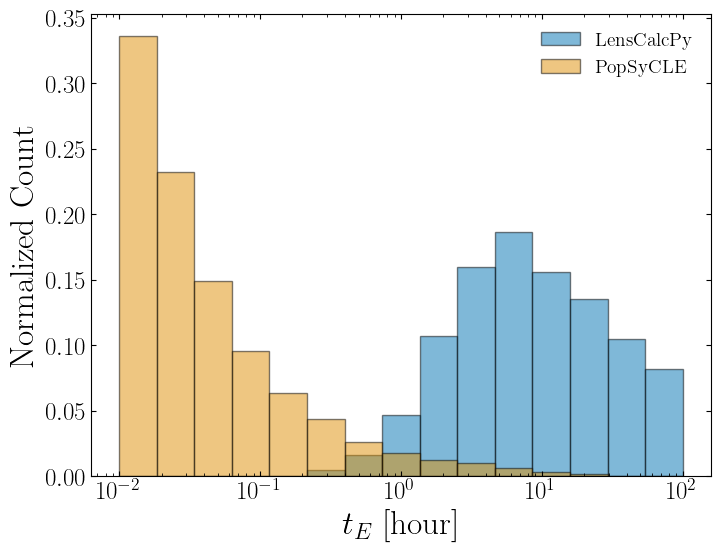

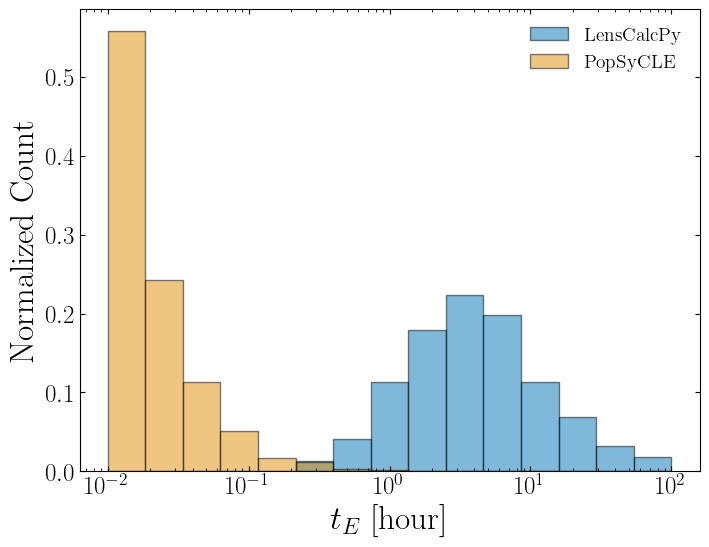

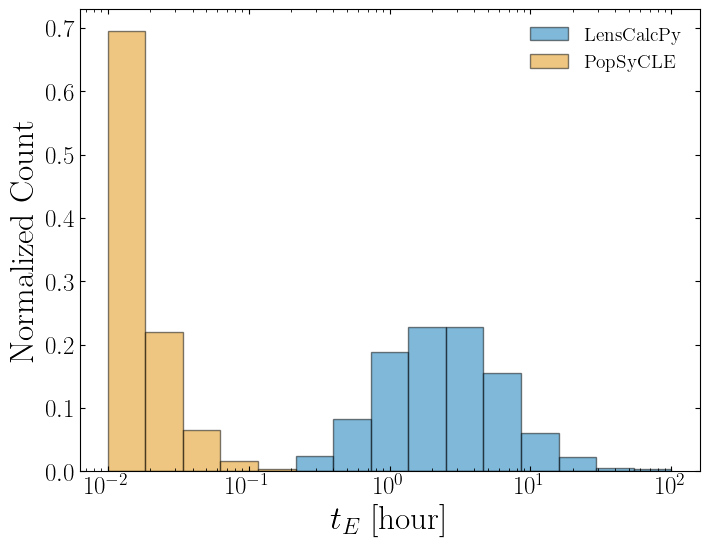

In [30]:
#With extended mass function, but cuts on t_duration at low and high
def plot_ffp_histograms(data_structure, nick_ffp_tes_data, num_samples=10000, num_bins=20):
    # bins = np.logspace(-2.5, 2, num_bins)
    bins = np.logspace(-2, 2, num_bins)


    for p_val, nick_ffp_tes_sampled in nick_ffp_tes_data.items():
        plt.figure()
        for entity, entity_data in data_structure.items():
            for finite_val, finite_data in entity_data.items():
                if finite_val:
                    continue
                for v_disp, v_disp_data in finite_data.items():
                    for p_or_mass, p_or_mass_data in v_disp_data.items():
                        if entity != 'ffp' or p_or_mass != p_val:
                            continue

                        # Calculate gamma(t) for each case
                        t_es_limited = np.logspace(np.log10(np.min(p_or_mass_data['t_es']))+0.1, np.log10(np.max(p_or_mass_data['t_es']))-0.1, 60)
                        gammas = np.array([gamma_of_t(p_or_mass_data['calculated_values'], t, t_es=p_or_mass_data['t_es']) for t in t_es_limited])
                        
                        # Sample crossing times
                        samples = sample_crossing_times(t_es_limited, gammas, num_samples)
                        
                        # Plot histogram
                        bin_counts, bin_edges = np.histogram(samples, bins=bins)
                        plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f'LensCalcPy', alpha=0.5)
                        # plt.axvline(np.median(samples), linestyle="--", alpha=0.5)
                        # plt.title("Unbound Exoplanet Yield")
                        
        # Plotting for Popsycle data
        bin_counts_popsycle_sampled, bin_edges_popsycle_sampled = np.histogram(nick_ffp_tes_sampled, bins=bins)
        plt.bar(bin_edges_popsycle_sampled[:-1], bin_counts_popsycle_sampled/np.sum(bin_counts_popsycle_sampled), width=np.diff(bin_edges_popsycle_sampled), align="edge", edgecolor="black", label=r"PopSyCLE", alpha=0.5)
        # plt.axvline(np.median(nick_ffp_tes_sampled), color='orange', linestyle="--", alpha=0.5)

        plt.xscale('log')
        plt.xlabel(r"$t_E$ [hour]")
        plt.ylabel("Normalized Count")
        plt.legend()
        # plt.savefig('draft_figures/ffp_tes_hist.pdf')
        plt.show()

plot_ffp_histograms(data_structure, nick_ffp_tes_data, num_bins=16)


In [51]:
#px, py, pz, vx, vy, vz
stars = np.load('popsycle_data/star.npy')
ffps = np.load('popsycle_data/ffp.npy')
ffps_smaller_r = np.load('popsycle_data/ffp_smaller_r.npy')

(-800.0, 600.0)

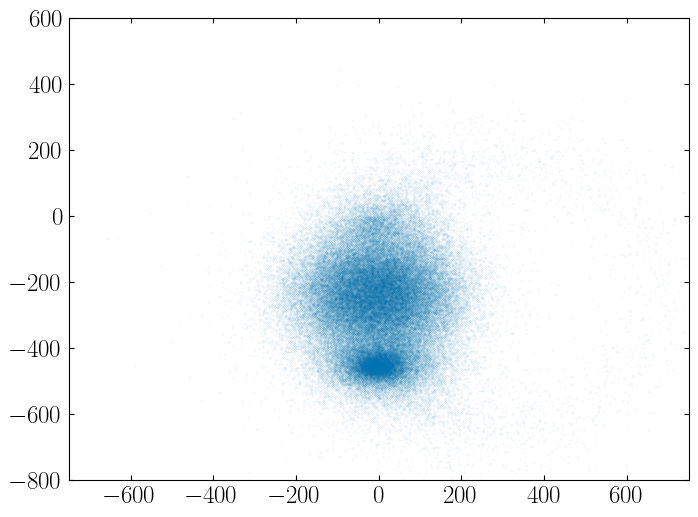

In [46]:
plt.plot(ffps[3], ffps[4], 'o', markersize=0.1, label='FFPs', alpha=0.3)
plt.xlim(-750, 750)
plt.ylim(-800, 600)

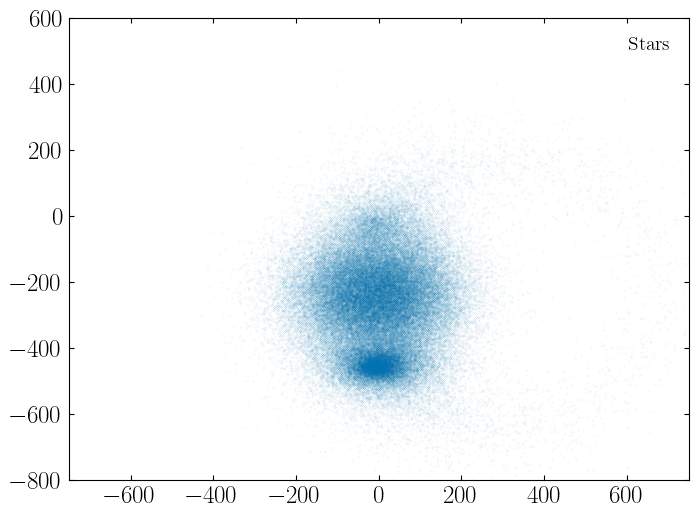

In [47]:
plt.plot(stars[3], stars[4], 'o', markersize=0.1, label='Stars', alpha=0.3)
plt.xlim(-750, 750)
plt.ylim(-800, 600)
plt.legend()

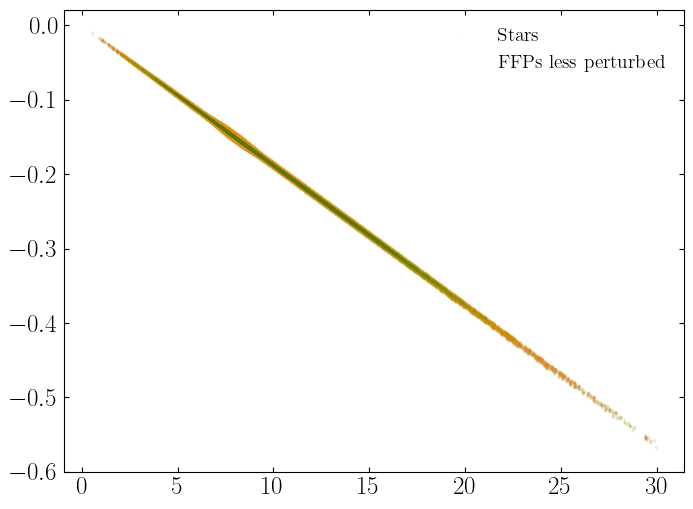

In [73]:
plt.plot(stars[0], stars[2], 'o', markersize=0.1, label='Stars', alpha=0.2)
# plt.plot(ffps[0], ffps[2], 'o', markersize=0.1, label='FFPs', alpha=0.05)
plt.plot(ffps_smaller_r[0], ffps_smaller_r[2], 'o', markersize=0.1, label='FFPs less perturbed', alpha=0.05)

plt.legend()

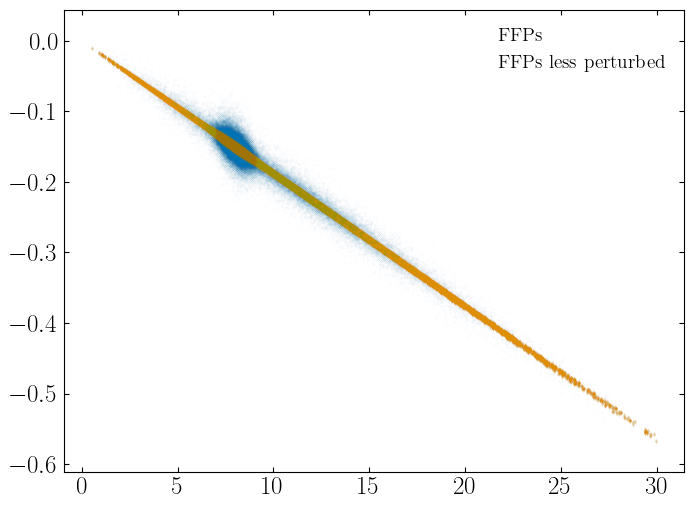

In [66]:


plt.legend()

## Stats

In [ ]:
def my_cdf(sample, x):
        # Counts how many observations are below or equal to x and normalize
        return np.sum(sample <= x) / len(sample)

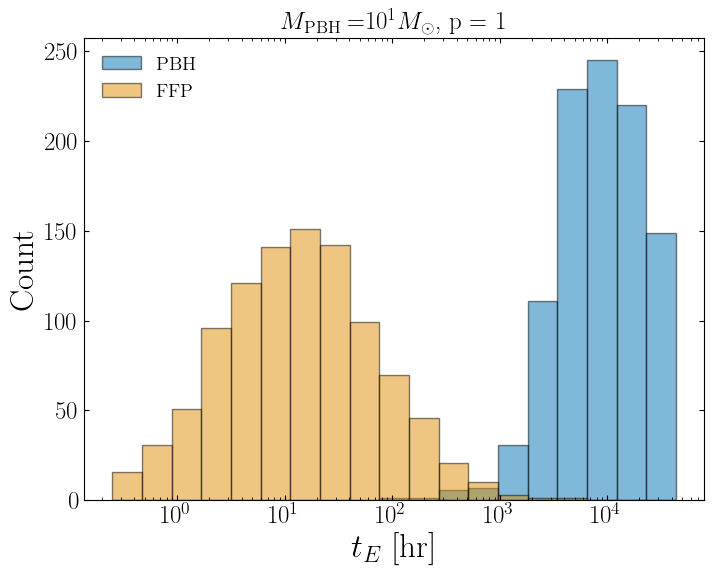

In [ ]:
num_samples_pbh = 1000
num_samples_ffp = 1000

samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh, num_samples_pbh)
samples_ffp = sample_crossing_times(t_es_limited, gammas_ffp, num_samples_ffp)

num_bins = 20
bin_counts_pbh, bin_edges_pbh = np.histogram(samples_pbh, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))
bin_counts_ffp, bin_edges_ffp = np.histogram(samples_ffp, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))

# Plotting the histogram
plt.bar(bin_edges_pbh[:-1], bin_counts_pbh, width=np.diff(bin_edges_pbh), align="edge", edgecolor="black", label="PBH", alpha=0.5)
plt.bar(bin_edges_ffp[:-1], bin_counts_ffp, width=np.diff(bin_edges_ffp), align="edge", edgecolor="black", label="FFP", alpha=0.5)
plt.xscale('log')
plt.xlabel("$t_E$ [hr]")
plt.ylabel("Count")
plt.title(r"$M_{\rm{PBH}} = $"  + scientific_format_less(s.pbh.mass) + r"$M_\odot$, p = {}".format(s.ffp.p))
plt.legend()
plt.show()

In [ ]:
def ks_2samp(sample1, sample2):
     # Gets all unique observations
    observations = np.unique(np.concatenate((sample1, sample2)))
    
    # Computes the CDF for both samples at each observation
    cdf_sample1 = np.array([my_cdf(sample1, x) for x in observations])
    cdf_sample2 = np.array([my_cdf(sample2, x) for x in observations])

    # Computes the KS statistic
    D_ks = np.max(np.abs(cdf_sample1 - cdf_sample2))

    # Calculates the P-Value based on the two-sided test
    m, n = float(len(sample1)), float(len(sample2))
    #Should this just be m or n if they're the same length?
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(D_ks, np.round(en))
#     print(D_ks, np.sqrt((m + n)/(m * n))*1.36)
    # p_value = stats.kstwo.sf(D_ks, np.round(np.sqrt(en)))

    return {"ks_stat": D_ks, "p_value" : p_value}

In [ ]:
num_samples_pbh_temp = 0
while True:
    samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh, num_samples_pbh_temp)
    samples_ffp = sample_crossing_times(t_es_limited, gammas_ffp, num_samples_ffp)
    samples_both = np.concatenate((samples_pbh, samples_ffp))
    ks = ks_2samp(samples_ffp, samples_both)
    if ks["p_value"] < 0.05:
        break
    num_samples_pbh_temp += 5

print("Fraction of pbh samples needed to distinguish: ", num_samples_pbh_temp/num_samples_ffp)

NameError: name 'gammas_pbh' is not defined

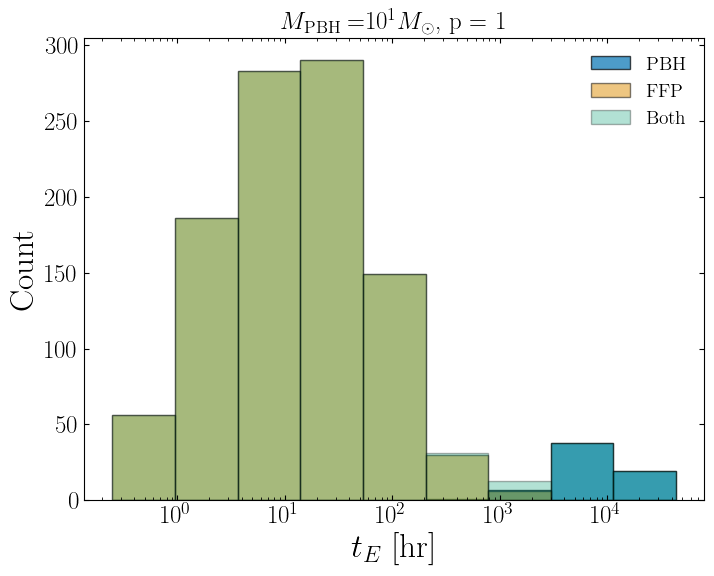

In [ ]:
num_bins = 10
bin_counts_pbh, bin_edges_pbh = np.histogram(samples_pbh, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))
bin_counts_ffp, bin_edges_ffp = np.histogram(samples_ffp, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))
bin_counts_both, bin_edges_both = np.histogram(samples_both, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))

# Plotting the histogram
plt.bar(bin_edges_pbh[:-1], bin_counts_pbh, width=np.diff(bin_edges_pbh), align="edge", edgecolor="black", label="PBH", alpha=0.7)
plt.bar(bin_edges_ffp[:-1], bin_counts_ffp, width=np.diff(bin_edges_ffp), align="edge", edgecolor="black", label="FFP", alpha=0.5)
plt.bar(bin_edges_both[:-1], bin_counts_both, width=np.diff(bin_edges_both), align="edge", edgecolor="black", label="Both", alpha=0.3)

plt.xscale('log')
plt.xlabel("$t_E$ [hr]")
plt.ylabel("Count")
plt.title(r"$M_{\rm{PBH}} = $"  + scientific_format_less(s.pbh.mass) + r"$M_\odot$, p = {}".format(s.ffp.p))
plt.legend()
plt.show()

## Old Mass Comparison

In [16]:
ms = np.logspace(-9, -3, 30)

In [17]:
s.add_ffp(p, m_min = 1e-9, m_max = 1e-3)

def differential_rate_mw_mass(m, tcad = s.cadence*2, tobs=s.obs_time, finite=True):
    return s.ffp.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite, epsabs=0, epsrel=1e-1)
    # return s.ffp.differential_rate_mw_mass(m, tcad=tcad, tobs=tobs, finite=finite)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, finite=True)
    diff_rates_ffp_mw_finite  = list(tqdm(pool.imap(func, ms), total=len(ms)))
diff_rates_ffp_mw_finite = np.array(diff_rates_ffp_mw_finite)

with Pool() as pool:
    func = functools.partial(differential_rate_mw_mass, finite=False)
    diff_rates_ffp_mw_point  = list(tqdm(pool.imap(func, ms), total=len(ms)))
diff_rates_ffp_mw_point = np.array(diff_rates_ffp_mw_point)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_ou

In [19]:
ms_limited = np.logspace(-8.9, -3.1, 100)

def create_interp_log(ms, diff_rates):
    return interp1d(np.log10(ms), np.log10(diff_rates))

diff_rates_finite_interp_log = create_interp_log(ms, diff_rates_ffp_mw_finite)
diff_rates_point_interp_log = create_interp_log(ms, diff_rates_ffp_mw_point)

def create_diff_rates_interp(interp_log):
    def diff_rates_interp(m):
        return 10**interp_log(np.log10(m))
    return diff_rates_interp

diff_rates_interp_finite = create_diff_rates_interp(diff_rates_finite_interp_log)
diff_rates_interp_point = create_diff_rates_interp(diff_rates_point_interp_log)

def quad_integration(func, m, min_ms, median_ms, max_ms, epsabs=0, epsrel=1e-1):
    return quad(func, m*10**(-0.1), m*10**(0.1), epsabs=epsabs, epsrel=epsrel, points=[min_ms, median_ms, max_ms])[0]

min_ms = min(ms)
median_ms = np.median(ms)
max_ms = max(ms)

gamma_of_ms_finite = np.array([quad_integration(diff_rates_interp_finite, m, min_ms, median_ms, max_ms) for m in ms_limited])
gamma_of_ms_point = np.array([quad_integration(diff_rates_interp_point, m, min_ms, median_ms, max_ms) for m in ms_limited])


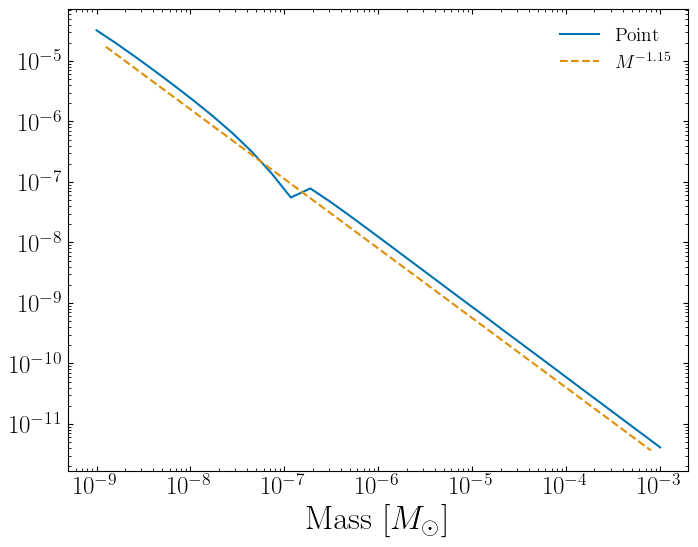

In [124]:
plt.plot(ms, diff_rates_ffp_mw_point, label="Point")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Mass [$M_\odot$]")
plt.plot(ms_limited, 1e-15*ms_limited**(-1.15), label=r"$M^{-1.15}$", ls="--")
plt.legend()
plt.show()


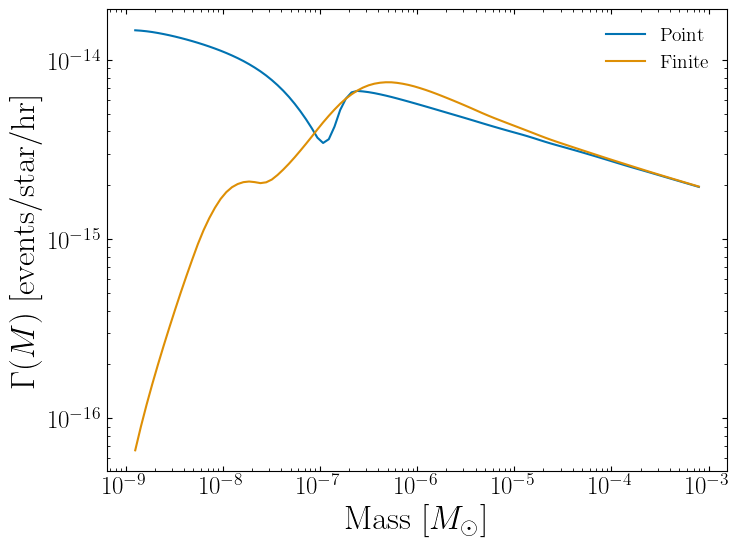

In [120]:
plt.plot(ms_limited, gamma_of_ms_point, label="Point")
plt.plot(ms_limited, gamma_of_ms_finite, label="Finite")

# plt.ylim(1e-24, 1e-21)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Mass [$M_\odot$]")
plt.ylabel(r"$\Gamma(M)$ [events/star/hr]")
plt.legend()
plt.show()

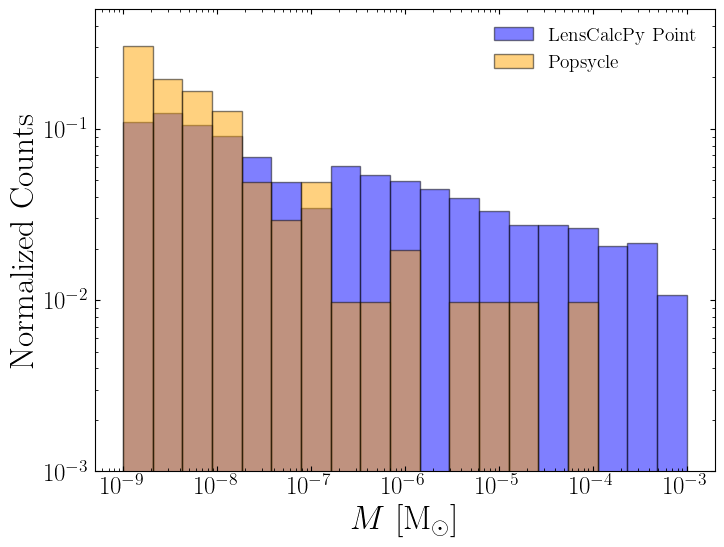

In [99]:
num_samples_ffp = 10000
bins_m = np.logspace(-9,-3,20)
samples_ffp_point_m = sample_crossing_times(ms_limited, gamma_of_ms_point, num_samples_ffp)
bin_counts_ffp_point_m, bin_edges_ffp_point_m = np.histogram(samples_ffp_point_m, bins=bins_m, density=False)
plt.bar(bin_edges_ffp_point_m[:-1], bin_counts_ffp_point_m/np.sum(bin_counts_ffp_point_m), width=np.diff(bin_edges_ffp_point_m), align="edge", edgecolor="black", label=r"LensCalcPy Point", alpha=0.5, color='blue')

bin_counts_popsycle_m, bin_edges_popsycle_m = np.histogram(nick_ffp_masses, bins=bins_m, density=False)
plt.bar(bin_edges_popsycle_m[:-1], bin_counts_popsycle_m/np.sum(bin_counts_popsycle_m), width=np.diff(bin_edges_popsycle_m), align="edge", edgecolor="black", label=r"Popsycle", alpha=0.5,color='orange')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$M$ [M$_\odot$]")
plt.ylabel("Normalized Counts")

plt.ylim(1e-3, 5e-1)
plt.legend()
plt.show()

In [52]:
pre_event_masses_ffps = pd.read_csv('popsycle_data/ffp_mass_1x.csv', header=None).values.flatten()
pre_event_masses_ffps_flat = pd.read_csv('popsycle_data/mass_p_0_20x.csv', header=None).values.flatten()


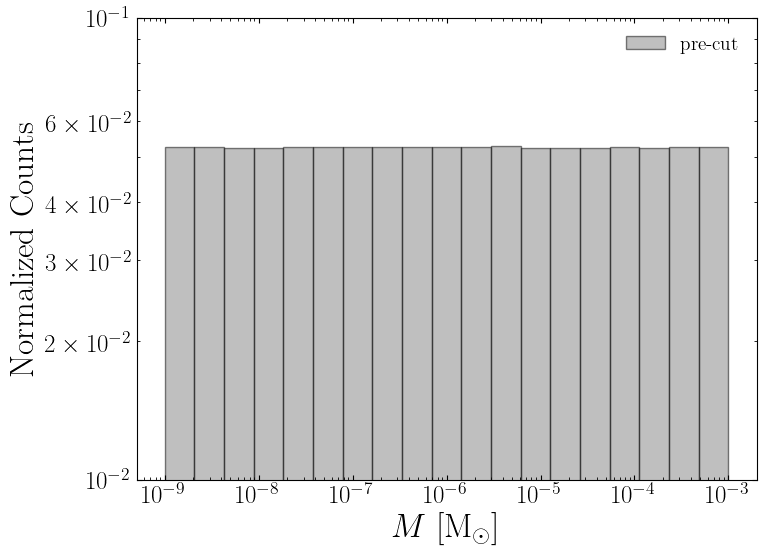

In [59]:
bins_m = np.logspace(-9,-3,20)

bin_counts_popsycle_m_pre, bin_edges_popsycle_m_pre = np.histogram(pre_event_masses_ffps_flat, bins=bins_m, density=False)
plt.bar(bin_edges_popsycle_m_pre[:-1], bin_counts_popsycle_m_pre/np.sum(bin_counts_popsycle_m_pre), width=np.diff(bin_edges_popsycle_m_pre), align="edge", edgecolor="black", label=r"pre-cut", alpha=0.5,color='gray')

plt.ylim(1e-2, 1e-1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$M$ [M$_\odot$]")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

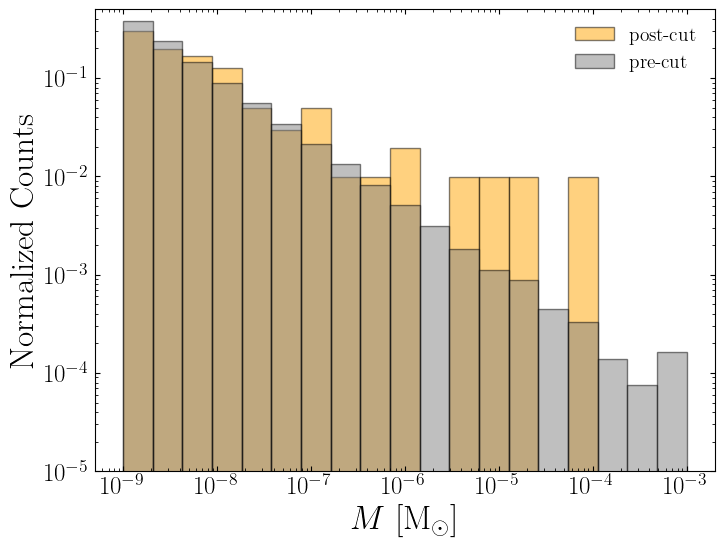

In [104]:
bin_counts_popsycle_m, bin_edges_popsycle_m = np.histogram(nick_ffp_masses, bins=bins_m, density=False)
plt.bar(bin_edges_popsycle_m[:-1], bin_counts_popsycle_m/np.sum(bin_counts_popsycle_m), width=np.diff(bin_edges_popsycle_m), align="edge", edgecolor="black", label=r"post-cut", alpha=0.5,color='orange')

bin_counts_popsycle_m_pre, bin_edges_popsycle_m_pre = np.histogram(pre_event_masses_ffps, bins=bins_m, density=False)
plt.bar(bin_edges_popsycle_m_pre[:-1], bin_counts_popsycle_m_pre/np.sum(bin_counts_popsycle_m_pre), width=np.diff(bin_edges_popsycle_m_pre), align="edge", edgecolor="black", label=r"pre-cut", alpha=0.5,color='gray')

plt.ylim(1e-5, 5e-1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$M$ [M$_\odot$]")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

Scratchwork

In [213]:
def calc_sph_motion(vx, vy, vz, r, b, l):
    """
    Calculate velocities in the r directions and proper motions
    in l, b directions.

    Parameters
    ----------
    vx, vy, vz : float or array
        Heliocentric velocities vx, vy, and vz (in km/s)

    r, b, l : float or array
        Galactic coordinates r, b, and l (in kpc and degrees)

    Return
    ------
    vr, mu_b, mu_lcosb : float or array (in km/s and mas/yr)
        Radial velocity and proper motions

    """
    b = np.radians(b)
    l = np.radians(l)

    cosb = np.cos(b)
    sinb = np.sin(b)
    cosl = np.cos(l)
    sinl = np.sin(l)

    vr = vz * sinb + cosb * (vx * cosl + vy * sinl)
    vb = vz * cosb - sinb * (vx * cosl + vy * sinl)
    vl = vy * cosl - vx * sinl

    mu_b = vb / r
    mu_lcosb = vl / r

    ##########
    # Convert between radians*(km/s)/kpc into mas/year.
    # 1 kpc = 3.086 * 10^16 km, 1 year = 3.154 * 10^7 s, 2.063 * 10^8 mas = 1 rad
    # 1 radian*(km/s)/kpc = 0.2108 mas/yr
    #########
    conversion_fact = 0.2108
    mu_b = mu_b * conversion_fact
    mu_lcosb = mu_lcosb * conversion_fact

    return vr, mu_b, mu_lcosb

# Function to convert spherical velocities to Cartesian velocities
def sph_to_cartesian(v_sph, pos):
    r_dot, b_dot, l_dot = v_sph
    r, b, l = pos
    l = np.radians(l)
    b = np.radians(b)
    vx = r_dot*np.cos(b)*np.cos(l) - r*b_dot*np.sin(b)*np.cos(l) - r*l_dot*np.cos(b)*np.sin(l)
    vy = r_dot*np.cos(b)*np.sin(l) - r*b_dot*np.sin(b)*np.sin(l) + r*l_dot*np.cos(b)*np.cos(l)
    vz = r_dot*np.sin(b) + r*b_dot*np.cos(b)
    return [vx, vy, vz]

In [214]:
starPos1 = [7.78257417678833, -0.018601227301875935, 0.016396739533508602]
starPos2 = [7.782573762098301, -0.018601124163779216, 0.016396434296014145]
pbhPos1 = [7.276314604254684, -0.018601284224945756, 0.01639681167636597]
pbhPos2 = [7.276313346359349, -0.018601393966005075, 0.01639677623181188]

pbhMass = 3e-6
duration = 1825 * 24 * 3600 #in seconds
theta_E = 2.26363e-12 #in radians
full_transit_time = (0.23261582851409912 - 0.2325861006975174) *duration
kpc_to_km = 3.086e16  # kpc to km
mas_to_rad = 4.84814e-9  # mas to rad
day_to_s = 86400  # day to seconds
year_to_s = 31536000  # year to seconds

starPos1[0] *= kpc_to_km
pbhPos1[0] *= kpc_to_km
starPos2[0] *= kpc_to_km
pbhPos2[0] *= kpc_to_km

v_star_sph = [(starPos2[i] - starPos1[i])/duration for i in range(3)]
v_pbh_sph = [(pbhPos2[i] - pbhPos1[i])/duration for i in range(3)]

# Convert the spherical velocities to Cartesian velocities
v_star = sph_to_cartesian(v_star_sph, starPos1)
v_pbh = sph_to_cartesian(v_pbh_sph, pbhPos1)

starPos1[0] /= kpc_to_km 
pbhPos1[0] /= kpc_to_km 
starPos2[0] /= kpc_to_km 
pbhPos2[0] /= kpc_to_km 

# # Calculate the radial velocity and proper motions using the function
vr_star, mu_b_star, mu_lcosb_star = calc_sph_motion(v_star[0], v_star[1], v_star[2], starPos1[0], np.degrees(starPos1[1]), np.degrees(starPos1[2]))
vr_pbh, mu_b_pbh, mu_lcosb_pbh = calc_sph_motion(v_pbh[0], v_pbh[1], v_pbh[2], pbhPos1[0], np.degrees(pbhPos1[1]), np.degrees(pbhPos1[2]))

mu_b_star *= mas_to_rad / year_to_s
mu_b_pbh *= mas_to_rad / year_to_s
mu_lcosb_star *= mas_to_rad / year_to_s
mu_lcosb_pbh *= mas_to_rad / year_to_s

# Calculate the relative proper motions
mu_b_rel = mu_b_star - mu_b_pbh
mu_lcosb_rel = mu_lcosb_star - mu_lcosb_pbh

# Calculate the total relative proper motion and the Einstein time
v_rel = np.sqrt(mu_b_rel**2 + mu_lcosb_rel**2)
t_E = theta_E / v_rel

print("Einstein time:", t_E / day_to_s)
print("Full transit time:", full_transit_time / day_to_s)

Einstein time: 0.011923784044031301
Full transit time: 0.054253265261650085


In [215]:
einstein_rad(7.276, 3e-6, 7.78257)/7.276

2.279924455200288e-12